In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.feature_selection import RFE
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor

In [2]:
X_df = pd.read_csv('features.csv', index_col=0)
y_df = pd.read_csv('all_park_factors.csv').drop_duplicates()

In [3]:
dup_fix = y_df[y_df['ballpark'].duplicated(keep=False)]
g = dup_fix['g_home'].sum()
pf = ((dup_fix['park_factor'] * dup_fix['g_home']) / g).sum()
y_df = y_df.loc[~y_df['ballpark'].duplicated(keep=False),:].copy()
y_df.loc[-1,:] = pd.Series({'ballpark':'mokdong_baseball_stadium','park_factor':pf,'g_home':g,'lg':'kbo'})
y_df = y_df.reset_index(drop=True).set_index('ballpark')
y_df.loc[y_df['lg']!='mlb', 'park_factor'] *= 100.
y_df

,park_factor,g_home,lg,pa,obstruction_type
ballpark,,,,,
las_vegas_ballpark,110.524565,75.0,aaa,NaN,NaN
greater_nevada_field,126.656746,74.0,aaa,NaN,NaN
cheney_stadium,105.244338,75.0,aaa,NaN,NaN
rio_grande_credit_union_field_at_isotopes_park,129.356725,75.0,aaa,NaN,NaN
southwest_university_park,122.179487,75.0,aaa,NaN,structural_shadow
...,...,...,...,...,...
american_family_field,97.000000,NaN,mlb,57190.0,structural
oracle_park,97.000000,NaN,mlb,55227.0,NaN
citi_field,97.000000,NaN,mlb,58441.0,NaN


In [4]:
y_df = y_df.reindex(X_df.index)[['park_factor']]

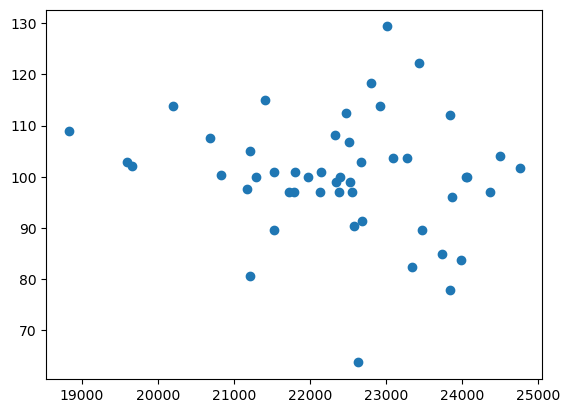

In [5]:
plt.scatter(X_df['lc_area'], y_df['park_factor'])

In [5]:
# sns.pairplot(X_df)

In [6]:
def data_processing(X_unscaled, y_unscaled):
    # split into train/test
    X_scaler = MinMaxScaler()
    y_scaler = MinMaxScaler()
    X = X_scaler.fit_transform(X_unscaled)
    y = y_scaler.fit_transform(y_unscaled)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2015)
    
    linear_model = LinearRegression()
    rfe = RFE(estimator=linear_model, n_features_to_select=5)
    rfe.fit(X_train, y_train)
    new_feature_cols = X_unscaled.columns[rfe.support_].tolist()
    return X, y, X_scaler, y_scaler, new_feature_cols

In [7]:
X, y, X_scaler, y_scaler, new_feature_cols = data_processing(X_df, y_df)

In [57]:
new_feature_cols

['lc_area', 'cf_area', 'rc_area', 'rf_area', 'total_area']

In [8]:
feature_cols = ['lf_area', 'lc_area', 'cf_area', 'rc_area', 'rf_area', 'elevation_m']

X = X[:, [x in feature_cols for x in X_df.columns.tolist()]]

In [39]:
X.shape

(49, 6)

In [108]:


models = {
    'Linear Regression': (LinearRegression(), False),
    'Ridge Regression': (Ridge(alpha=1), False),
    'Lasso Regression': (Lasso(alpha=0.1), False),
    'ElasticNet Regression': (ElasticNet(), False),
    'Random Forest': (RandomForestRegressor(), True),
    'XGBoost Regressor': (XGBRegressor(), True)
}
y_flat = y.flatten()
for name, (model, y_1d) in models.items():
    if y_1d:
        y_val = y_flat
    else:
        y_val = y
    scores = cross_val_score(model, X, y, cv=len(X), scoring='neg_mean_squared_error')
    print(f"{name} Mean MSE: {-scores.mean():.4f}, Std Dev: {scores.std():.4f}")
print('-'*50)

Linear Regression Mean MSE: 0.0271, Std Dev: 0.0422
Ridge Regression Mean MSE: 0.0257, Std Dev: 0.0441
Lasso Regression Mean MSE: 0.0316, Std Dev: 0.0582
ElasticNet Regression Mean MSE: 0.0316, Std Dev: 0.0582


c:\Users\mccap\anaconda3\envs\field-plot-env\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\mccap\anaconda3\envs\field-plot-env\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\mccap\anaconda3\envs\field-plot-env\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\mccap\anaconda3\envs\field-plot-env\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed

Random Forest Mean MSE: 0.0308, Std Dev: 0.0504
XGBoost Regressor Mean MSE: 0.0389, Std Dev: 0.0628
--------------------------------------------------


In [120]:
model = LinearRegression()
mask =X_df.index != 'coors_field'

model.fit(X[mask,:], y[mask])
prediction = model.predict(X[~mask])

In [121]:
y_scaler.inverse_transform(prediction)

array([[114.92547186]])

In [111]:
y_df.loc['coors_field',:]

park_factor    112.0
Name: coors_field, dtype: float64

In [106]:
X.shape

(49, 19)

In [12]:
values = []
for stadium in X_df.index.to_list():
    model = Ridge(alpha=1)
    mask =X_df.index != stadium

    model.fit(X[mask,:], y[mask])
    prediction = y_scaler.inverse_transform(model.predict(X[~mask]))
    actual = y_df.loc[stadium,'park_factor']
    values.append({'ballpark':stadium, 'predicted':prediction[0][0], 'actual':actual})

In [14]:
values = pd.DataFrame(values).sort_values('ballpark')

In [15]:
values

,ballpark,predicted,actual
45,american_family_field,102.586053,97.000000
36,angels_stadium,95.797133,100.000000
9,autozone_park,99.139438,103.671604
38,busch_stadium,95.621218,100.000000
41,camden_yards,93.978842,99.000000
24,changwon_nc_park,97.651535,90.347166
23,cheongju_baseball_stadium,102.386204,97.689204
2,chickasaw_bricktown_ballpark,100.032325,77.765237
8,chs_field,102.844485,113.826484
47,citi_field,96.966684,97.000000


In [94]:
millville = {'orientation': 3.9892090041183574,
 'lf_depth': 310.1329209729035,
 'lc_depth': 326.4786164250165,
 'cf_depth': 336.41000970438546,
 'rc_depth': 330.1228612756279,
 'rf_depth': 308.6409102337052,
 'lf_area': 15973.35414745675,
 'lc_area': 17147.239045477865,
 'cf_area': 17520.83707989633,
 'rc_area': 16659.150026376956,
 'rf_area': 15696.047321129501,
 'total_area': 82995.86249942267,
 'avg_depth': 324.98920286974555,
 'temp_K': 287.1756,
 'u_wind': -0.14962485,
 'v_wind': -0.022247849,
 'out_to_cf_wind': 0.11569687091565625,
 'left_to_right_wind': 0.09745150887993102,
 'elevation_m': 12}

In [128]:
data = X_scaler.transform(pd.DataFrame(pd.Series(millville)).T)[:, [x in feature_cols for x in X_df.columns.tolist()]]

In [133]:
y_scaler.inverse_transform(model.predict(data))

array([[111.87534286]])

In [135]:
import os
import sys
SCRIPT_DIR = os.path.dirname(os.path.abspath('../geometric_feature_extraction/feature_extraction.py'))
sys.path.append(os.path.dirname(SCRIPT_DIR))

from geometric_feature_extraction.feature_extraction import predict_from_name, plot_field

In [149]:
values = values.set_index('ballpark')

[230.55676546 250.13694111] [231.93699763 248.75670894]
240.34685328576495
[229.0605474  223.91252986] [229.0605474  244.61601242]
229.0605473965195
dodger_stadium (-268.0, 268.0) (-78.0, 444.0)
[238.93407092 241.49723575] [240.20545552 240.20545552]
240.20545552104983
[242.9613121  242.76844853] [242.91032303 249.1763606 ]
242.95978955634848
coors_field (-268.0, 268.0) (-78.0, 444.0)
[234.1653491  235.94648969] [235.56731876 235.94648969]
235.9464896886382
[225.6807015  212.11300536] [225.6807015  234.54452002]
225.68070150380169
petco_park (-268.0, 268.0) (-78.0, 444.0)
[212.94634375 226.91213328] [215.52263222 224.33584481]
219.92923851290382
[219.87011901 216.6069794 ] [217.29383054 219.18326787]
218.23854920527805
millville_high_school_baseball_field (-268.0, 268.0) (-78.0, 444.0)


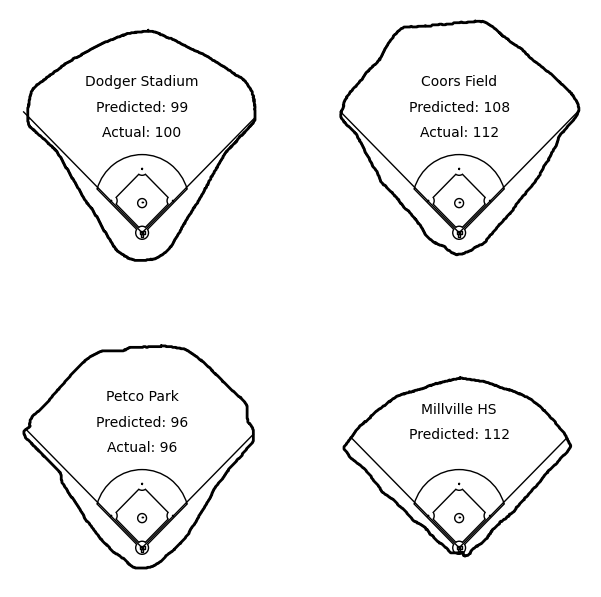

In [155]:
fig = plt.Figure(figsize=(7.5,7.5))

for i, stadium in enumerate(['dodger_stadium', 'coors_field','petco_park','millville_high_school_baseball_field']):
    ax = fig.add_subplot(221+i)
    ax.set_xlim(-268,268)
    ax.set_ylim(-78,444)
    plot_field(predict_from_name(stadium), ax)
    print(stadium, ax.get_xlim(), ax.get_ylim())
    if i==3:
        field = 'Millville HS'
    else:
        field = stadium.replace('_',' ').title()
        row = values.loc[stadium,:]
    if i < 3:
        ax.text(0, 300, field, ha='center', va='center')
        ax.text(0, 250, f'Predicted: {round(row["predicted"])}', ha='center', va='center')
        ax.text(0, 200, f'Actual: {round(row["actual"])}', ha='center', va='center')
    else:
        
        ax.text(0, 275, field, ha='center', va='center')
        ax.text(0, 225, f'Predicted: 112', ha='center', va='center')
    ax.axis('off')
    
fig

In [9]:
import pickle

model = Ridge(alpha=1)

model.fit(X, y)

with open('park_factor_components.pkl', 'wb') as f:
    pickle.dump({'model':model, 'x_scaler':X_scaler, 'y_scaler':y_scaler}, f)